# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 12, 21, 23, 27, 566387)

In [3]:
%load_ext autoreload
%autoreload 2

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(api_key_value="wOWQmzzHeITT5wlJ.FkOButuQ3XpDXSUO1LnTuaNfD7SPWolfF1hateoistsLFFsBF7upULn5z6qKPOIB")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163414
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
from pathlib import Path

path = Path('../../data/hopsworks-api-key.txt')
content = path.read_text()
print(content)
#print(HOPSWORKS_API_KEY)
print(os.environ)

wOWQmzzHeITT5wlJ.FkOButuQ3XpDXSUO1LnTuaNfD7SPWolfF1hateoistsLFFsBF7upULn5z6qKPOIB

environ({'SHELL': '/bin/bash', 'CONDA_EXE': '/opt/conda/bin/conda', '_CE_M': '', 'VERTEX_PRODUCT': 'WORKBENCH_INSTANCE', 'GRPC_FORK_SUPPORT_ENABLED': '0', 'DL_ANACONDA_HOME': '/opt/conda', 'FRAMEWORK_FILE_PATH': '/opt/deeplearning/metadata/framework', 'GOOGLE_CLOUD_PROJECT': 'id2223group14', 'POST_STARTUP_SCRIPT_PATH': '/opt/c2d/post_start.sh', 'DL_PATH_DEPS': '/opt/deeplearning/deps', 'DL_BIN_PATH': '/opt/deeplearning/bin', 'XML_CATALOG_FILES': 'file:///opt/conda/etc/xml/catalog file:///etc/xml/catalog', 'KERNEL_LAUNCH_TIMEOUT': '40', 'BINARIES_PATH': '/opt/deeplearning/binaries', 'PWD': '/home/jupyter/mlfs-book/notebooks/ch03', 'LOGNAME': 'jupyter', 'CONDA_PREFIX': '/opt/conda', 'JPY_SESSION_NAME': '/home/jupyter/mlfs-book/notebooks/ch03/4_air_quality_batch_inference.ipynb', 'TENSORBOARD_PROXY_URL': '/proxy/%PORT%/', 'PACKAGE_SOURCE_CODE_PATH': '/opt/deeplearning/src/third_party', 'JUPYTER_DEPS_PATH': 

## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [6]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [8]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.4176912E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [9]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by=['date'])
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
5,2024-11-13 00:00:00+00:00,6.35,0.0,15.778516,235.222092,stockholm
7,2024-11-14 00:00:00+00:00,6.30,0.0,15.273505,315.000092,stockholm
6,2024-11-15 00:00:00+00:00,6.95,0.0,9.114471,260.909790,stockholm
0,2024-11-16 00:00:00+00:00,10.75,0.0,21.868332,249.775055,stockholm
2,2024-11-17 00:00:00+00:00,7.30,0.0,26.089447,242.020615,stockholm
3,2024-11-18 00:00:00+00:00,5.05,1.6,18.892282,59.036320,stockholm
4,2024-11-19 00:00:00+00:00,1.90,0.1,17.935081,308.480225,stockholm
8,2024-11-20 00:00:00+00:00,2.15,0.0,6.109403,44.999897,stockholm
1,2024-11-21 00:00:00+00:00,3.00,0.7,17.877180,25.016869,stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
5,2024-11-13 00:00:00+00:00,6.35,0.0,15.778516,235.222092,stockholm,4.995158
7,2024-11-14 00:00:00+00:00,6.30,0.0,15.273505,315.000092,stockholm,1.785491
6,2024-11-15 00:00:00+00:00,6.95,0.0,9.114471,260.909790,stockholm,1.469350
0,2024-11-16 00:00:00+00:00,10.75,0.0,21.868332,249.775055,stockholm,1.720356
2,2024-11-17 00:00:00+00:00,7.30,0.0,26.089447,242.020615,stockholm,2.416532
3,2024-11-18 00:00:00+00:00,5.05,1.6,18.892282,59.036320,stockholm,2.598647
4,2024-11-19 00:00:00+00:00,1.90,0.1,17.935081,308.480225,stockholm,0.691362
8,2024-11-20 00:00:00+00:00,2.15,0.0,6.109403,44.999897,stockholm,2.992073
1,2024-11-21 00:00:00+00:00,3.00,0.7,17.877180,25.016869,stockholm,0.259337


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 5 to 1
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 396.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
5,2024-11-13 00:00:00+00:00,6.35,0.0,15.778516,235.222092,stockholm,4.995158,Radarvagen,sweden,1
7,2024-11-14 00:00:00+00:00,6.30,0.0,15.273505,315.000092,stockholm,1.785491,Radarvagen,sweden,2
6,2024-11-15 00:00:00+00:00,6.95,0.0,9.114471,260.909790,stockholm,1.469350,Radarvagen,sweden,3
0,2024-11-16 00:00:00+00:00,10.75,0.0,21.868332,249.775055,stockholm,1.720356,Radarvagen,sweden,4
2,2024-11-17 00:00:00+00:00,7.30,0.0,26.089447,242.020615,stockholm,2.416532,Radarvagen,sweden,5
3,2024-11-18 00:00:00+00:00,5.05,1.6,18.892282,59.036320,stockholm,2.598647,Radarvagen,sweden,6
4,2024-11-19 00:00:00+00:00,1.90,0.1,17.935081,308.480225,stockholm,0.691362,Radarvagen,sweden,7
8,2024-11-20 00:00:00+00:00,2.15,0.0,6.109403,44.999897,stockholm,2.992073,Radarvagen,sweden,8
1,2024-11-21 00:00:00+00:00,3.00,0.7,17.877180,25.016869,stockholm,0.259337,Radarvagen,sweden,9


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 5 to 1
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

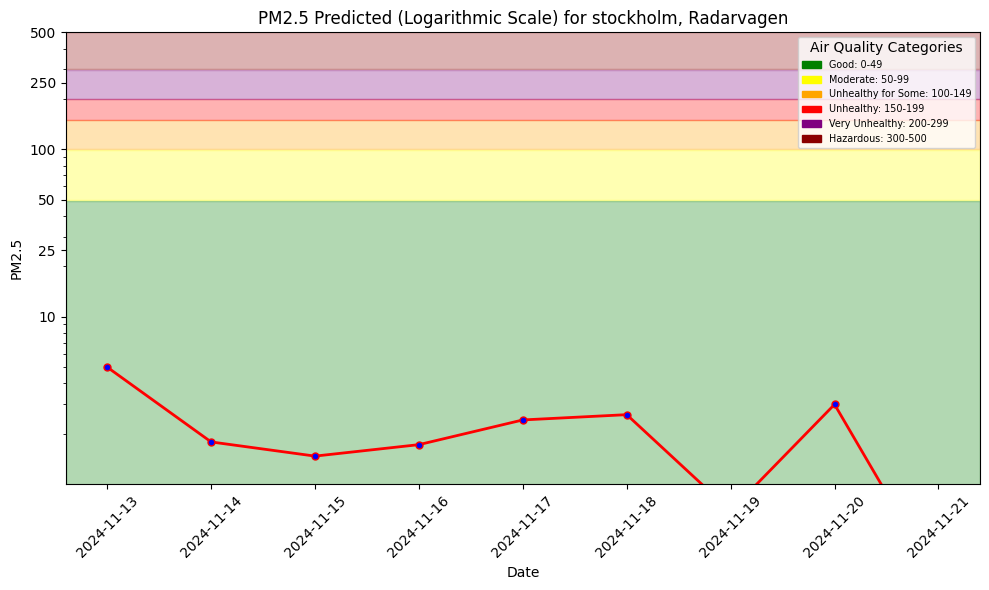

In [14]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [15]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)


In [16]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1163414/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f9859fedde0>, None)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-13 00:00:00+00:00,6.35,0.0,15.778516,235.222092,stockholm,4.995158,Radarvagen,sweden,1
1,2024-11-12 00:00:00+00:00,4.95,0.0,9.199390,300.579132,stockholm,2.602701,Radarvagen,sweden,1
2,2024-11-16 00:00:00+00:00,10.50,0.0,24.967499,245.282578,stockholm,1.927217,Radarvagen,sweden,1


In [18]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 


,date,pm25,country,city,street,url
0,2024-10-15 00:00:00+00:00,0.80,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1,2022-08-14 00:00:00+00:00,1.83,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
2,2023-08-08 00:00:00+00:00,0.93,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
3,2024-07-22 00:00:00+00:00,6.85,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
4,2023-03-04 00:00:00+00:00,0.60,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
...,...,...,...,...,...,...
1790,2023-06-06 00:00:00+00:00,1.80,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1791,2023-02-26 00:00:00+00:00,1.00,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1792,2022-04-03 00:00:00+00:00,0.70,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1793,2024-01-06 00:00:00+00:00,2.20,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912


In [19]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)

import pandas as pd
from datetime import timedelta

# Fabricate a new value for the next day
new_row = {
    'date': pd.Timestamp(hindcast_df['date'].iloc[-1] + timedelta(days=1)),  # Next day based on last date in DataFrame
    'predicted_pm25': 2.5,  # Example fabricated predicted value
    'pm25': 2.3  # Example fabricated actual value
}

# Convert the dictionary to a DataFrame
new_row_df = pd.DataFrame([new_row])

# Append the new row to the existing DataFrame
hindcast_df = pd.concat([hindcast_df, new_row_df], ignore_index=True)
    
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-12 00:00:00+00:00,2.602701,8.0
1,2024-11-13 00:00:00+00:00,2.500000,2.3


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

                        date  predicted_pm25  pm25
0  2024-11-12 00:00:00+00:00        2.602701   8.0
1  2024-11-13 00:00:00+00:00        2.500000   2.3


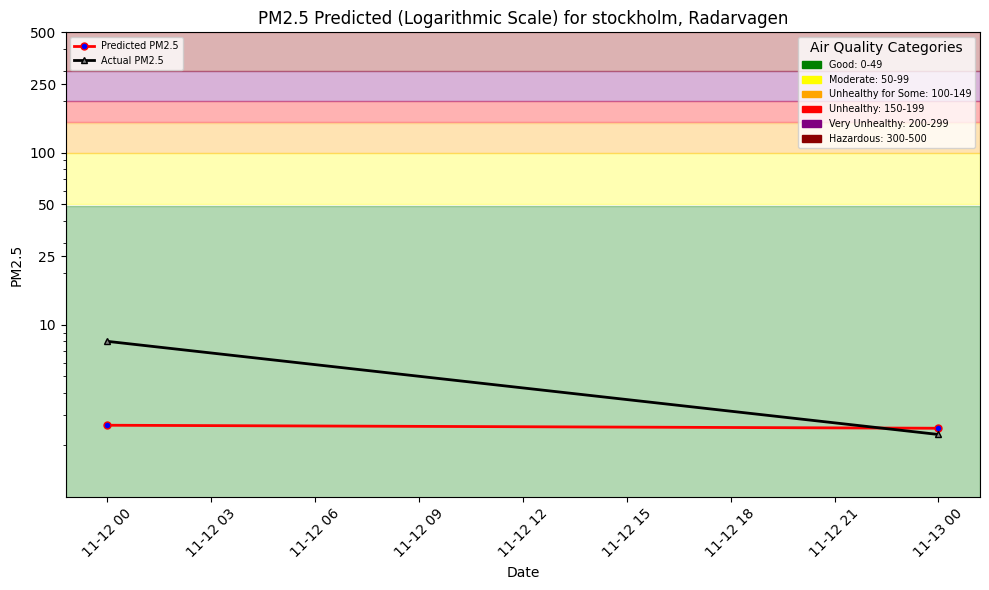

In [20]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
print(hindcast_df)

plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---